In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq
import geopandas as gpd
import seaborn as sns

#Packages
import matplotlib.ticker as mtick
from scipy import stats
pd.set_option('display.max_columns', None)

from scipy.stats import skew, kurtosis

import pygris
from shapely.geometry import Polygon

import shapely

In [8]:
df = pd.read_parquet("C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/FimaNfipClaims.parquet.gzip")

# First Dataset [Use Zip Code]
# No geographic values missing, no shapefiles missing, post 2000

In [11]:
df_geographic_unique = df[['state', 'reportedZipCode', 'countyCode', 'censusTract', 'censusBlockGroupFips', 'latitude', 'longitude', 'yearOfLoss']].drop_duplicates()

In [12]:
df_geographic_unique = df_geographic_unique.dropna(subset=['latitude', 'censusBlockGroupFips', 'reportedZipCode', 'countyCode'])

In [13]:
df_geographic_unique.head()

,state,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,yearOfLoss
0,CA,92056.0,6073.0,6.073019e+09,6.073019e+10,33.2,-117.3,1998
1,LA,70131.0,22071.0,2.207100e+10,2.207100e+11,29.9,-90.0,2005
2,FL,32566.0,12113.0,1.211301e+10,1.211301e+11,30.4,-86.9,1998
3,SC,29902.0,45013.0,4.501300e+10,4.501300e+11,32.4,-80.7,1994
4,FL,32940.0,12009.0,1.200906e+10,1.200906e+11,28.3,-80.7,1996


In [6]:
print(sum(df_geographic_unique['state'].isna()))
print(sum(df_geographic_unique['reportedZipCode'].isna()))
print(sum(df_geographic_unique['countyCode'].isna()))
print(sum(df_geographic_unique['censusTract'].isna()))
print(sum(df_geographic_unique['censusBlockGroupFips'].isna()))
print(sum(df_geographic_unique['latitude'].isna()))
print(sum(df_geographic_unique['yearOfLoss'].isna()))

0
0
0
0
0
0
0


In [14]:
df_geographic_unique['reportedZipCode'] = df_geographic_unique['reportedZipCode'].dropna().astype(int).astype(str)
df_geographic_unique['reportedZipCode'] = [zipcode.zfill(5) for zipcode in df_geographic_unique['reportedZipCode']]

df_geographic_unique['censusBlockGroupFips'] = [str(int(float(i))) for i in df_geographic_unique['censusBlockGroupFips']]
df_geographic_unique['censusBlockGroupFips'] = [censusBG.zfill(12) for censusBG in df_geographic_unique['censusBlockGroupFips']]

df_geographic_unique['countyCode'] = [str(int(float(i))) for i in df_geographic_unique['countyCode']]
df_geographic_unique['countyCode'] = [censusBG.zfill(5) for censusBG in df_geographic_unique['countyCode']]

df_geographic_unique['censusTract'] = [str(int(float(i))) for i in df_geographic_unique['censusTract']]
df_geographic_unique['censusTract'] = [censusBG.zfill(11) for censusBG in df_geographic_unique['censusTract']]

In [15]:
# Define bins and labels for yearOfLoss_1990_2021
bins_1990_2021 = [df_geographic_unique['yearOfLoss'].min(), 2000, 2010, 2020, df_geographic_unique['yearOfLoss'].max() + 1]
labels_1990_2021 = [1990, 2000, 2010, 2020]

df_geographic_unique['yearOfLoss_1990_2021'] = pd.cut(df_geographic_unique['yearOfLoss'], bins=bins_1990_2021, labels=labels_1990_2021, right=False).astype(int)

df_geographic_unique = df_geographic_unique.drop(columns='yearOfLoss')

In [16]:
df_geographic_unique.head()

,state,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,yearOfLoss_1990_2021
0,CA,92056,06073,06073018512,060730185123,33.2,-117.3,1990
1,LA,70131,22071,22071000616,220710006163,29.9,-90.0,2000
2,FL,32566,12113,12113010815,121130108152,30.4,-86.9,1990
3,SC,29902,45013,45013000700,450130007002,32.4,-80.7,1990
4,FL,32940,12009,12009063107,120090631073,28.3,-80.7,1990


## Read shapefiles

In [10]:
states = pygris.states()

state_df = states[['STUSPS', 'NAME', 'geometry']]

Using the default year of 2021


In [11]:
#Checking if all states found in our dataset are in the US Census Bureau TIGER/Line and cartographic boundary shapefiles

unique_states = df_geographic_unique['state'].unique()
state_STUSPS_unique = state_df['STUSPS'].unique()

np.all(np.isin(unique_states, state_STUSPS_unique))

True

In [12]:
# Read the parquet file
df_read = pd.read_parquet("C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/lat_long_geometry.parquet.gzip")

# Convert the WKT strings back to geometries
lat_long_df = gpd.GeoDataFrame(df_read, geometry=df_read['geometry'].apply(lambda x: shapely.wkt.loads(x)))

In [6]:
chunk_size = 40000 
chunks = [x for x in range(0, 320000, chunk_size)]

gdf_list = []

for start in chunks:
    end = start + chunk_size
    temp_df = pd.read_parquet(f"C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/BG_geometry_{start}_{end}.parquet.gzip")
    gdf_read = gpd.GeoDataFrame(temp_df, geometry=temp_df['geometry'].apply(lambda x: shapely.wkt.loads(x)))
    gdf_list.append(gdf_read)

# Concatenate all GeoDataFrames in the list into a single GeoDataFrame
BG_df= pd.concat(gdf_list, ignore_index=True)

In [14]:
chunk_size = 25000 
chunks = [x for x in range(0, 100000, chunk_size)]

gdf_list = []

for start in chunks:
    end = start + chunk_size
    temp_df = pd.read_parquet(f"C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/zipcode_geometry_{start}_{end}.parquet.gzip")
    gdf_read = gpd.GeoDataFrame(temp_df, geometry=temp_df['geometry'].apply(lambda x: shapely.wkt.loads(x)))
    gdf_list.append(gdf_read)
    
# Concatenate all GeoDataFrames in the list into a single GeoDataFrame
zipcode_df = pd.concat(gdf_list, ignore_index=True)

zipcode_df['year'] = zipcode_df['year'].replace({2012: 2010, 2021: 2020})
zipcode_df = zipcode_df.drop_duplicates(subset=['ZIPcode', 'year'])

In [4]:
# Read the parquet file
df_read = pd.read_parquet("C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/County_geometry.parquet.gzip")

# Convert the WKT strings back to geometries
County_df = gpd.GeoDataFrame(df_read, geometry=df_read['geometry'].apply(lambda x: shapely.wkt.loads(x)))

County_df['year'] = County_df['year'].replace({2012: 2010, 2021: 2020})
County_df = County_df.drop_duplicates(subset=['CountyID', 'year'])

In [6]:
# Read the parquet file for Tract_shapefile

chunk_size = 30000 
chunks = [x for x in range(0, 180000, chunk_size)]

gdf_list = []

for start in chunks:
    end = start + chunk_size
    temp_df = pd.read_parquet(f"C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/Tract_geometry_{start}_{end}.parquet.gzip")
    gdf_read = gpd.GeoDataFrame(temp_df, geometry=temp_df['geometry'].apply(lambda x: shapely.wkt.loads(x)))
    gdf_list.append(gdf_read)

# Concatenate all GeoDataFrames in the list into a single GeoDataFrame
Tract_df= pd.concat(gdf_list, ignore_index=True)

## Geometry Intersection creation

In [17]:
state_df.rename(columns={'geometry': 'geometry_state'}, inplace=True)
lat_long_df.rename(columns={'geometry': 'geometry_lat_long'}, inplace=True)
BG_df.rename(columns={'geometry': 'geometry_BG'}, inplace=True)
zipcode_df.rename(columns={'geometry': 'geometry_zipcode'}, inplace=True)
County_df.rename(columns={'geometry': 'geometry_county'}, inplace=True)
Tract_df.rename(columns={'geometry': 'geometry_tract'}, inplace=True)

C:\Users\Asus\AppData\Local\Temp\ipykernel_1708\2417984689.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_df.rename(columns={'geometry': 'geometry_state'}, inplace=True)


In [17]:
df_geographic_unique.head()

,state,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,yearOfLoss_1990_2021
0,CA,92056,06073,06073018512,060730185123,33.2,-117.3,1990
1,LA,70131,22071,22071000616,220710006163,29.9,-90.0,2000
2,FL,32566,12113,12113010815,121130108152,30.4,-86.9,1990
3,SC,29902,45013,45013000700,450130007002,32.4,-80.7,1990
4,FL,32940,12009,12009063107,120090631073,28.3,-80.7,1990


In [19]:
# Filter for post 2000

df_geographic_unique = df_geographic_unique[df_geographic_unique['yearOfLoss_1990_2021']!=1990]

In [20]:
# Setting the multi-index on lat_long_df
lat_long_df.set_index(['latitude', 'longitude'], inplace=True)

# Mapping the values
df_geographic_unique['geometry_lat_long'] = df_geographic_unique.set_index(['latitude', 'longitude']).index.map(lat_long_df['geometry_lat_long'])

# Resetting the index of lat_long_df (optional, but good practice)
lat_long_df.reset_index(inplace=True)

In [18]:
# Initial mapping with multi-index
BG_df.set_index(['GEOID', 'year'], inplace=True)
df_geographic_unique['geometry_BG'] = df_geographic_unique.set_index(['censusBlockGroupFips', 'yearOfLoss_1990_2021']).index.map(BG_df['geometry_BG'])

# Find rows with NaN values 
na_rows = df_geographic_unique['geometry_BG'].isna()

# # Reset index of BG_df
# df_single_index = BG_df.reset_index()

# # Sort by 'year' in descending order
# df_single_index = df_single_index.sort_values(by='year', ascending=False)

# # Drop duplicates based on the 'GEOID' column. Keep the first occurrence.
# df_single_index = df_single_index.drop_duplicates(subset='GEOID', keep='first')

# # Map these rows using only the 'GEOID'
# df_geographic_unique.loc[na_rows, 'geometry_BG'] = df_geographic_unique.loc[na_rows, 'censusBlockGroupFips'].map(df_single_index.set_index('GEOID')['geometry_BG'])

# Resetting the index of BG_df (return to multi-index)
BG_df.reset_index(inplace=True)

In [21]:
test = df_geographic_unique.loc[na_rows, ]

print(test['yearOfLoss_1990_2021'].value_counts())

1990    107328
2000     40653
2020      9094
2010       316
Name: yearOfLoss_1990_2021, dtype: int64


In [54]:
# Initial mapping with multi-index
zipcode_df.set_index(['ZIPcode', 'year'], inplace=True)
df_geographic_unique['geometry_zipcode'] = df_geographic_unique.set_index(['reportedZipCode', 'yearOfLoss_1990_2021']).index.map(zipcode_df['geometry_zipcode'])

# Find rows with NaN values 
na_rows = df_geographic_unique['geometry_zipcode'].isna()

# # Reset index of BG_df
# df_single_index = zipcode_df.reset_index()

# # Sort by 'year' in descending order
# df_single_index = df_single_index.sort_values(by='year', ascending=False)

# # Drop duplicates based on the 'GEOID' column. Keep the first occurrence.
# df_single_index = df_single_index.drop_duplicates(subset='ZIPcode', keep='first')

# # Map these rows using only the 'GEOID'
# df_geographic_unique.loc[na_rows, 'geometry_zipcode'] = df_geographic_unique.loc[na_rows, 'reportedZipCode'].map(df_single_index.set_index('ZIPcode')['geometry_zipcode'])

# Resetting the index of BG_df (return to multi-index)
zipcode_df.reset_index(inplace=True)

In [28]:
# Setting the multi-index on lat_long_df
state_df.set_index(['STUSPS'], inplace=True)

# Mapping the values
df_geographic_unique['geometry_state'] = df_geographic_unique.set_index(['state']).index.map(state_df['geometry_state'])

# Resetting the index of lat_long_df (optional, but good practice)
state_df.reset_index(inplace=True)

In [34]:
# Initial mapping with multi-index
County_df.set_index(['CountyID', 'year'], inplace=True)
df_geographic_unique['geometry_county'] = df_geographic_unique.set_index(['countyCode', 'yearOfLoss_1990_2021']).index.map(County_df['geometry_county'])

# Find rows with NaN values
na_rows = df_geographic_unique['geometry_county'].isna()

# # Reset index of County_df
# df_single_index = County_df.reset_index()

# # Sort by 'year' in descending order
# df_single_index = df_single_index.sort_values(by='year', ascending=False)

# # Drop duplicates based on the 'countyCode' column. Keep the first occurrence.
# df_single_index = df_single_index.drop_duplicates(subset='CountyID', keep='first')

# # Map these rows using only the 'countyCode'
# df_geographic_unique.loc[na_rows, 'geometry_county'] = df_geographic_unique.loc[na_rows, 'countyCode'].map(df_single_index.set_index('CountyID')['geometry_county'])

# Resetting the index of County_df (return to multi-index)
County_df.reset_index(inplace=True)

In [35]:
sum(na_rows)

139

In [36]:
# Initial mapping with multi-index
Tract_df.set_index(['censusTractID', 'year'], inplace=True)
df_geographic_unique['geometry_tract'] = df_geographic_unique.set_index(['censusTract', 'yearOfLoss_1990_2021']).index.map(Tract_df['geometry_tract'])

# Find rows with NaN values
na_rows = df_geographic_unique['geometry_tract'].isna()

# # Reset index of County_df
# df_single_index = Tract_df.reset_index()

# # Sort by 'year' in descending order
# df_single_index = df_single_index.sort_values(by='year', ascending=False)

# # Drop duplicates based on the 'countyCode' column. Keep the first occurrence.
# df_single_index = df_single_index.drop_duplicates(subset='censusTractID', keep='first')

# # Map these rows using only the 'countyCode'
# df_geographic_unique.loc[na_rows, 'geometry_tract'] = df_geographic_unique.loc[na_rows, 'censusTract'].map(df_single_index.set_index('censusTractID')['geometry_tract'])

# Resetting the index of County_df (return to multi-index)
Tract_df.reset_index(inplace=True)

In [37]:
sum(na_rows)

42628

In [41]:
Tract_df[Tract_df['year']==1990].shape[0]

0

## Drop rows with missing shapefiles

In [ ]:
df_geographic_unique = df_geographic_unique[(df_geographic_unique['geometry_BG'].notna())
                              & (df_geographic_unique['geometry_county'].notna())
                              & (df_geographic_unique['geometry_zipcode'].notna())
                              & (df_geographic_unique['geometry_tract'].notna())]

## Creating the intersections

In [ ]:
import geopandas as gpd
from shapely.geometry import Polygon
from itertools import product
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df_geographic_unique.columns

In [ ]:
# Create an empty GeoDataFrame to store the intersection results
new_unit_df = gpd.GeoDataFrame(columns=['reportedZipCode', 'countyCode', 'censusTract',
                                       'censusBlockGroupFips', 'latitude', 'longitude', 'year', 'state', 'geometry_zipcode',
                                       'geometry_county', 'geometry_tract','geometry_BG','geometry_lat_long','state_geometry'])

# Iterate through each row in BG_df_1990 and each row in lat_long_df to find intersections
for idx_unit, row_unit in df_geographic_unique.iterrows():
    year = row_unit['yearOfLoss_1990_2021']
    bg_id = row_unit['censusBlockGroupFips']
    bg_geometry = row_unit['geometry_BG']
    tract_id = row_unit['censusTract']
    tract_geometry = row_unit['geometry_tract']
    county_id = row_unit['countyCode']
    county_geometry = row_unit['geometry_county']
    state = row_unit['state']
    state_geometry = row_unit['geometry_state']
    lat_long_geometry = row_unit['geometry_lat_long']
    lat = row_unit['latitude']
    long = row_unit['longitude']
    zipcode_geometry = row_unit['geometry_zipcode']
    zipcode = row_unit['reportedZipCode']
    
    # Compute intersection geometry
    intersection_geometry = bg_geometry.intersection(lat_long_geometry).intersection(zipcode_geometry).intersection(county_geometry).intersection(state_geometry).intersection(tract_geometry)

    if intersection_geometry is None or intersection_geometry.is_empty:
        new_unit_df = pd.concat([new_unit_df, pd.DataFrame({
            'reportedZipCode': [zipcode],
            'countyCode': [county_id],
            'censusTract': [tract_id],
            'censusBlockGroupFips': [bg_id],
            'latitude': [lat],
            'longitude': [long],
            'year': [year],
            'state': [state],
            'geometry_zipcode': [zipcode_geometry],
            'geometry_county': [county_geometry],
            'geometry_tract': [tract_geometry],
            'geometry_BG': [bg_geometry],
            'geometry_lat_long': [lat_long_geometry],
            'state_geometry': [state_geometry]
        })], ignore_index=True)

In [ ]:
new_unit_df

## Test

In [60]:
BG_df.head()

,GEOID,year,geometry_BG
0,020900009002,2020,"POLYGON ((-147.96856 64.77841, -147.96852 64.7..."
1,020200007011,2020,"POLYGON ((-149.77843 61.22629, -149.77740 61.2..."
2,021700007032,2020,"POLYGON ((-149.63359 61.55695, -149.63313 61.5..."
3,021700007012,2020,"POLYGON ((-149.72265 61.58833, -149.72221 61.5..."
4,021700013002,2020,"POLYGON ((-149.17952 61.53109, -149.17766 61.5..."


Average Area: 3607711.618139065 square kilometers


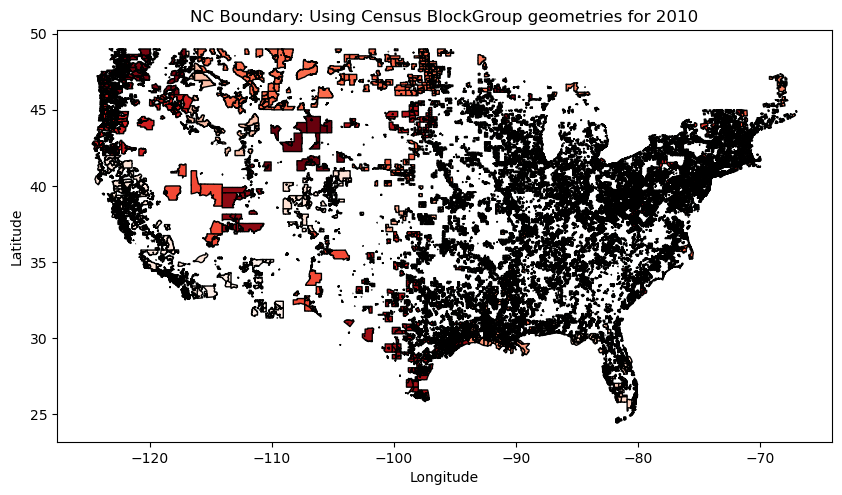

In [70]:
visualize = BG_df[BG_df['year'] == 2000]
# Find the centroid for each geometry
centroids = visualize.geometry_BG.centroid

# Filter the rows where the y-coordinate (latitude) of the centroid is greater than 42
visualize = visualize[(centroids.y < 55) & (centroids.y > 22) & (centroids.x < -50) & (centroids.x > -140)]
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(visualize, geometry='geometry_BG')

# Set the current CRS to WGS 84 (assuming your data is in latitude and longitude)
gdf.crs = "EPSG:4326"

# Project the GeoDataFrame to a suitable CRS (using Web Mercator here for demonstration)
gdf_projected = gdf.to_crs(epsg=3857)

# Compute the average area in square meters
average_area_m2 = gdf_projected.geometry.area.sum()
# Convert the area from square meters to square kilometers
average_area_km2 = average_area_m2 / 1e6
print(f"Average Area: {average_area_km2} square kilometers")

# Plot using the 'viridis' colormap
gdf.plot(edgecolor="black", cmap='Reds', figsize=(10, 10))

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Using Census BlockGroup geometries for 2000')

plt.show()

Average Area: 5896245.864909399 square kilometers


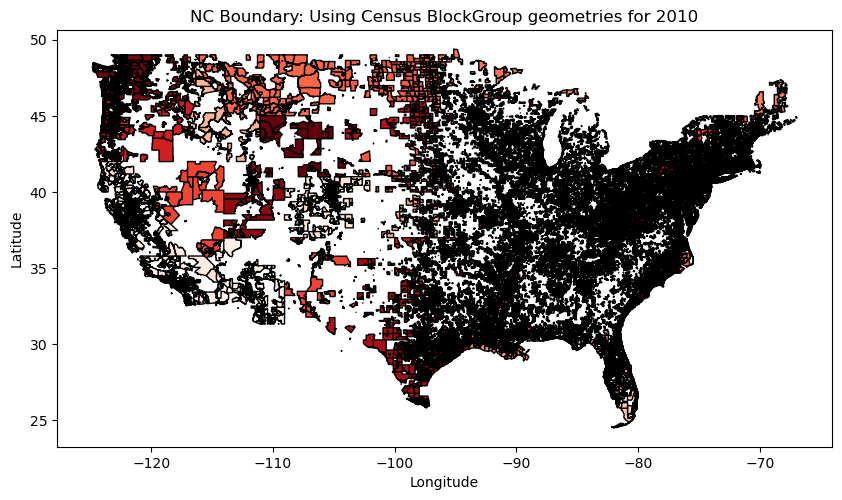

In [72]:
visualize = BG_df[BG_df['year'] == 2010]
# Find the centroid for each geometry
centroids = visualize.geometry_BG.centroid

# Filter the rows where the y-coordinate (latitude) of the centroid is greater than 42
visualize = visualize[(centroids.y < 55) & (centroids.y > 22) & (centroids.x < -50) & (centroids.x > -140)]
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(visualize, geometry='geometry_BG')

# Set the current CRS to WGS 84 (assuming your data is in latitude and longitude)
gdf.crs = "EPSG:4326"

# Project the GeoDataFrame to a suitable CRS (using Web Mercator here for demonstration)
gdf_projected = gdf.to_crs(epsg=3857)

# Compute the average area in square meters
average_area_m2 = gdf_projected.geometry.area.sum()
# Convert the area from square meters to square kilometers
average_area_km2 = average_area_m2 / 1e6
print(f"Average Area: {average_area_km2} square kilometers")

# Plot using the 'viridis' colormap
gdf.plot(edgecolor="black", cmap='Reds', figsize=(10, 10))

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Using Census BlockGroup geometries for 2010')

plt.show()

Average Area: 4294477.787755974 square kilometers


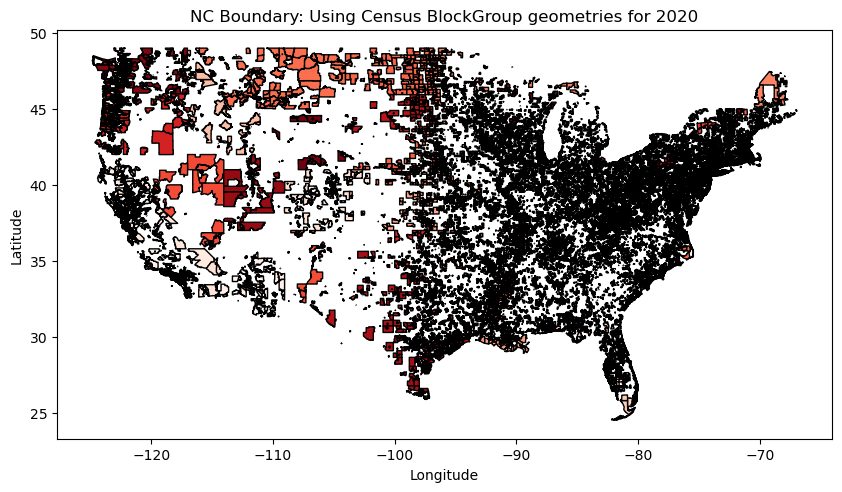

In [73]:
visualize = BG_df[BG_df['year'] == 2020]
# Find the centroid for each geometry
centroids = visualize.geometry_BG.centroid

# Filter the rows where the y-coordinate (latitude) of the centroid is greater than 42
visualize = visualize[(centroids.y < 55) & (centroids.y > 22) & (centroids.x < -50) & (centroids.x > -140)]
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(visualize, geometry='geometry_BG')

# Set the current CRS to WGS 84 (assuming your data is in latitude and longitude)
gdf.crs = "EPSG:4326"

# Project the GeoDataFrame to a suitable CRS (using Web Mercator here for demonstration)
gdf_projected = gdf.to_crs(epsg=3857)

# Compute the average area in square meters
average_area_m2 = gdf_projected.geometry.area.sum()
# Convert the area from square meters to square kilometers
average_area_km2 = average_area_m2 / 1e6
print(f"Average Area: {average_area_km2} square kilometers")

# Plot using the 'viridis' colormap
gdf.plot(edgecolor="black", cmap='Reds', figsize=(10, 10))

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Using Census BlockGroup geometries for 2020')

plt.show()

Average Area: 2149637.7687702905 square kilometers


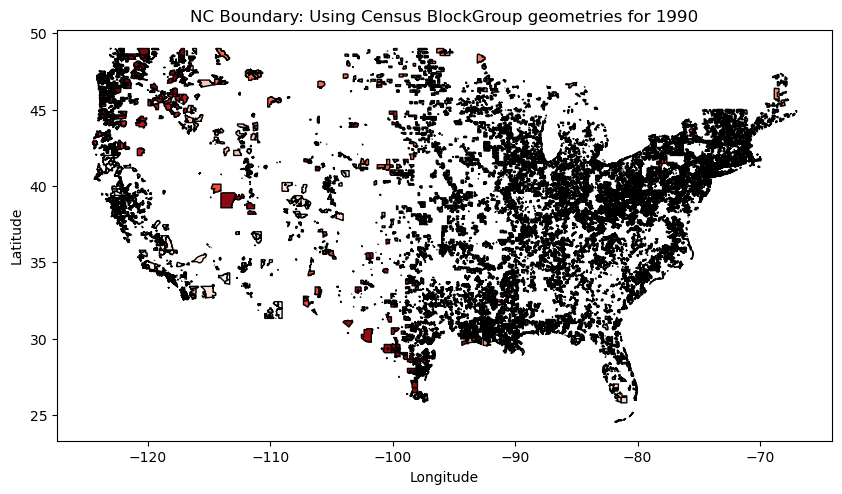

In [74]:
visualize = BG_df[BG_df['year'] == 1990]
# Find the centroid for each geometry
centroids = visualize.geometry_BG.centroid

# Filter the rows where the y-coordinate (latitude) of the centroid is greater than 42
visualize = visualize[(centroids.y < 55) & (centroids.y > 22) & (centroids.x < -50) & (centroids.x > -140)]
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(visualize, geometry='geometry_BG')

# Set the current CRS to WGS 84 (assuming your data is in latitude and longitude)
gdf.crs = "EPSG:4326"

# Project the GeoDataFrame to a suitable CRS (using Web Mercator here for demonstration)
gdf_projected = gdf.to_crs(epsg=3857)

# Compute the average area in square meters
average_area_m2 = gdf_projected.geometry.area.sum()
# Convert the area from square meters to square kilometers
average_area_km2 = average_area_m2 / 1e6
print(f"Average Area: {average_area_km2} square kilometers")

# Plot using the 'viridis' colormap
gdf.plot(edgecolor="black", cmap='Reds', figsize=(10, 10))

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Using Census BlockGroup geometries for 1990')

plt.show()